In [1]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

import pandas as pd
import numpy as np

import torch

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import f1_score, recall_score, precision_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [105]:
def load_results(filename:str, labels:str, load_line:bool = False, load_outlines:bool = False):
    """ 
    Load results from a file and return a pandas dataframe with the results.

    Args:
        filename (str): The name of the file to load.
        labels (str): The name of the file containing the labels.
        load_line (bool, optional): If True, the function will expect a line labelled dataset and return the aggregated results per rid.
        load_outlines (bool, optional): If True, the function will expect the output of an outlines prompt (no hidden states and model answers are labels)

    Returns:
        pd.DataFrame: A pandas dataframe with the results.

    """
    results = torch.load(paths.RESULTS_PATH/"ms-diag"/filename, map_location=torch.device('cpu'))
    labels = torch.load(paths.RESULTS_PATH/"ms-diag"/labels, map_location=torch.device('cpu'))

    output = {"model_answers": results.pop("model_answers")}

    if not load_outlines:
        
        # Get prediction through cosine similarity
        last_hidden_states = results.pop("last_hidden_states")
        last_hidden_states = last_hidden_states.cpu()
        preds = get_prediction(last_hidden_states, labels_hs=labels[1], label_names=labels[0])

        # If rag
        if "rag" in filename:
            output["model_answers_mapped"] = preds + ["no information found" for _ in range(len(output["model_answers"])-len(preds))]
        else:
            output["model_answers_mapped"] = preds
    
    # Map from string answer to int
    label2id = {'primär progrediente Multiple Sklerose': 0,
            'sekundär progrediente Multiple Sklerose': 2,
            'schubförmige remittierende Multiple Sklerose': 1,
            'other': 3,
            'no information found': 3}
    
    if load_outlines:
        key = "model_answers"
    else:
        key = "model_answers_mapped"
    
    output["preds"] = [label2id[i] for i in output[key]]
    output["exact_match"] = [res in label2id.keys() for res in output["model_answers"]]

    output["labels"] = results["labels"]
    output["rid"] = results["rid"]
    output["text"] = results["text"]

    if "whole_prompt" in results.keys():
        whole_prompt = results["whole_prompt"]
        if "rag" in filename:
            output["whole_prompt"] = whole_prompt + ["no information found" for _ in range(len(output["model_answers"])-len(whole_prompt))]
        else:
            output["whole_prompt"] = whole_prompt
    
    df = pd.DataFrame(output)

    if load_line:
        return convert_line2report(df, filename)
    else:
        return df

def get_prediction(hs: torch.Tensor, labels_hs: torch.Tensor, label_names: list):
    """ 
    Get the prediction for a given hidden state and labels.

    Args:
        hs (torch.Tensor): The hidden state to use for prediction. Shape (n_samples, n_features).
        labels_hs (torch.Tensor): The hidden states of the labels. Shape (n_labels, n_features).
        label_names (list): The names of the labels. The order of the names should match the order of the hs-labels in dim 0.

    Returns:
        torch.Tensor: The predicted labels.

    """
    answer_idx = np.argmax(cosine_similarity(hs, labels_hs), axis=1)
    model_answer = [label_names[i] for i in answer_idx]
    return model_answer

def convert_line2report(rids:list[str], preds:list[int])->list[int]:
    """ 
    Aggregeates the results of a line labelled dataset in a majority vote fashion.

    Args:
        rids (list[str]): The rids of the samples.
        preds (list[int]): The predictions of the samples.

    Returns:
        list[int]: The aggregated predictions.
        
    """
    df = pd.DataFrame({"rid":rids, "preds":preds})

    # If len value counts >1 and value counts[0] is 3, then majority vote is value counts[1]
    results = []
    rid = []
    for _df in df.groupby("rid"):
        if _df[1].preds.value_counts().shape[0] > 1 and _df[1].preds.value_counts().iloc[0] == 3:
            result = df.loc[df.rid == _df[0], "preds"] = _df[1].preds.value_counts().index[1]
        else:
            result = df.loc[df.rid == _df[0], "preds"] = _df[1].preds.value_counts().index[0]
        results.append(result)
        rid.append(_df[0])
    return result


def summarize_performance(files: list[str], *args, **kwargs):

    """ 
    Summarizes the performance of a given strategy (Base, RAG, Outlines) for all prompting strategies.

    Args:
        files (list[str]): The files to summarize.
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    Returns:
        pd.DataFrame: A pandas dataframe with the summarized results.

    """
    dfs = []
    for filename in files:
        strategies = ["zero_shot_vanilla", "zero_shot_instruction", "few_shot_vanilla", "few_shot_instruction"]
        
        # Set strategy name to whatever is found in the filename
        for strategy in strategies:
            if strategy in filename:
                break

        results = load_results(filename=filename, labels=kwargs["labels"], load_line=kwargs["load_line"], load_outlines=kwargs["load_outlines"])

        # Target names
        metric_dict = classification_report(y_true=results["labels"], y_pred=results["preds"], output_dict=True)

        # Create a dictionary with flattened keys
        _df = pd.json_normalize(metric_dict)
        

        # Add additional information
        _df["strategy"] = strategy

        # Look for exact label
        _df["valid_label"] = sum(results["exact_match"])/len(results)

        # Reorder columns
        reordered_cols = _df.columns[-4:].append(_df.columns[:-4])
        _df = _df[reordered_cols]

        dfs.append(_df)

    return pd.concat(dfs)

# Llama2-MedTuned-13B

## RAG

In [106]:
pd.set_option('display.max_columns', None)
summarize_performance(["ms-diag_Llama2-MedTuned-13b_4bit_all_test_zero_shot_vanilla_rag.pt",
                       "ms-diag_Llama2-MedTuned-13b_4bit_all_test_zero_shot_instruction_rag.pt",
                       "ms-diag_Llama2-MedTuned-13b_4bit_all_test_few_shot_vanilla_rag.pt",
                       "ms-diag_Llama2-MedTuned-13b_4bit_all_test_few_shot_instruction_rag.pt",
                       ], labels="label_encodings_Llama2-MedTuned-13b.pt", load_line=False, load_outlines=False)

,weighted avg.f1-score,weighted avg.support,strategy,valid_label,accuracy,0.precision,0.recall,0.f1-score,0.support,1.precision,1.recall,1.f1-score,1.support,2.precision,2.recall,2.f1-score,2.support,3.precision,3.recall,3.f1-score,3.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall
0,0.922680,58.0,zero_shot_vanilla,0.224138,0.913793,0.500000,1.0,0.666667,4.0,1.00000,0.871795,0.931507,39.0,1.0,1.000000,1.0,3.0,0.923077,1.0,0.960000,12.0,0.855769,0.967949,0.889543,58.0,0.949602,0.913793
0,0.895873,58.0,zero_shot_instruction,0.224138,0.879310,0.400000,1.0,0.571429,4.0,1.00000,0.820513,0.901408,39.0,1.0,1.000000,1.0,3.0,0.923077,1.0,0.960000,12.0,0.830769,0.955128,0.858209,58.0,0.942706,0.879310
0,0.763267,58.0,few_shot_vanilla,0.241379,0.724138,0.235294,1.0,0.380952,4.0,1.00000,0.641026,0.781250,39.0,0.5,0.333333,0.4,3.0,0.857143,1.0,0.923077,12.0,0.648109,0.743590,0.621320,58.0,0.891843,0.724138
0,0.846144,58.0,few_shot_instruction,0.224138,0.827586,0.333333,1.0,0.500000,4.0,0.96875,0.794872,0.873239,39.0,1.0,0.333333,0.5,3.0,0.923077,1.0,0.960000,12.0,0.806290,0.782051,0.708310,58.0,0.917095,0.827586


## Outlines

In [107]:
pd.set_option('display.max_columns', None)
summarize_performance(["ms-diag_outlines_Llama2-MedTuned-13b_4bit_all_test_zero_shot_vanilla.pt",
                       "ms-diag_outlines_Llama2-MedTuned-13b_4bit_all_test_zero_shot_instruction.pt",
                       "ms-diag_outlines_Llama2-MedTuned-13b_4bit_all_test_few_shot_vanilla.pt",
                       "ms-diag_outlines_Llama2-MedTuned-13b_4bit_all_test_few_shot_instruction.pt",
                       ], labels="label_encodings_Llama2-MedTuned-7b.pt", load_line=False, load_outlines=True)

,weighted avg.f1-score,weighted avg.support,strategy,valid_label,accuracy,0.precision,0.recall,0.f1-score,0.support,1.precision,1.recall,1.f1-score,1.support,2.precision,2.recall,2.f1-score,2.support,3.precision,3.recall,3.f1-score,3.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall
0,0.101649,58.0,zero_shot_vanilla,1.0,0.120690,0.095238,1.00,0.173913,4.0,0.500000,0.076923,0.133333,39.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,12.0,0.148810,0.269231,0.076812,58.0,0.342775,0.120690
0,0.602877,58.0,zero_shot_instruction,1.0,0.655172,0.200000,0.75,0.315789,4.0,0.833333,0.897436,0.864198,39.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,12.0,0.258333,0.411859,0.294997,58.0,0.574138,0.655172
0,0.380564,58.0,few_shot_vanilla,1.0,0.327586,0.111111,1.00,0.200000,4.0,0.937500,0.384615,0.545455,39.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,12.0,0.262153,0.346154,0.186364,58.0,0.638051,0.327586
0,0.661919,58.0,few_shot_instruction,1.0,0.706897,0.210526,1.00,0.347826,4.0,0.948718,0.948718,0.948718,39.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,12.0,0.289811,0.487179,0.324136,58.0,0.652450,0.706897


## RAG + Outlines

In [108]:
pd.set_option('display.max_columns', None)
summarize_performance(["ms-diag_outlines_Llama2-MedTuned-13b_4bit_all_test_zero_shot_vanilla_rag.pt",
                       "ms-diag_outlines_Llama2-MedTuned-13b_4bit_all_test_zero_shot_instruction_rag.pt",
                       "ms-diag_outlines_Llama2-MedTuned-13b_4bit_all_test_few_shot_vanilla_rag.pt",
                       "ms-diag_outlines_Llama2-MedTuned-13b_4bit_all_test_few_shot_instruction_rag.pt",
                       ], labels="label_encodings_Llama2-MedTuned-13b.pt", load_line=False, load_outlines=True)

,weighted avg.f1-score,weighted avg.support,strategy,valid_label,accuracy,0.precision,0.recall,0.f1-score,0.support,1.precision,1.recall,1.f1-score,1.support,2.precision,2.recall,2.f1-score,2.support,3.precision,3.recall,3.f1-score,3.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall
0,0.263187,58.0,zero_shot_vanilla,1.0,0.310345,0.250000,0.5,0.333333,4.0,1.000000,0.025641,0.050000,39.0,0.083333,1.0,0.153846,3.0,0.923077,1.0,0.96,12.0,0.564103,0.631410,0.374295,58.0,0.884947,0.310345
0,0.251777,58.0,zero_shot_instruction,1.0,0.293103,0.088889,1.0,0.163265,4.0,1.000000,0.025641,0.050000,39.0,0.000000,0.0,0.000000,3.0,1.000000,1.0,1.00,12.0,0.522222,0.506410,0.303316,58.0,0.885441,0.293103
0,0.867920,58.0,few_shot_vanilla,1.0,0.844828,0.800000,1.0,0.888889,4.0,0.942857,0.846154,0.891892,39.0,0.000000,0.0,0.000000,3.0,1.000000,1.0,1.00,12.0,0.685714,0.711538,0.695195,58.0,0.896059,0.844828
0,0.812289,58.0,few_shot_instruction,1.0,0.793103,0.266667,1.0,0.421053,4.0,0.967742,0.769231,0.857143,39.0,0.000000,0.0,0.000000,3.0,1.000000,1.0,1.00,12.0,0.558602,0.692308,0.569549,58.0,0.876010,0.793103


# Llama 7B

## Base

In [109]:
pd.set_option('display.max_columns', None)
summarize_performance(["ms-diag_Llama2-MedTuned-7b_4bit_all_test_zero_shot_vanilla.pt",
                       "ms-diag_Llama2-MedTuned-7b_4bit_all_test_zero_shot_instruction.pt",
                       "ms-diag_Llama2-MedTuned-7b_4bit_all_test_few_shot_vanilla.pt",
                       "ms-diag_Llama2-MedTuned-7b_4bit_all_test_few_shot_instruction.pt",
                       ], labels="label_encodings_Llama2-MedTuned-7b.pt", load_line=False, load_outlines=False)

,weighted avg.f1-score,weighted avg.support,strategy,valid_label,accuracy,0.precision,0.recall,0.f1-score,0.support,1.precision,1.recall,1.f1-score,1.support,2.precision,2.recall,2.f1-score,2.support,3.precision,3.recall,3.f1-score,3.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall
0,0.358741,58.0,zero_shot_vanilla,0.086207,0.310345,0.125000,0.50,0.200000,4.0,0.888889,0.205128,0.333333,39.0,0.086957,0.666667,0.153846,3.0,0.600000,0.500000,0.545455,12.0,0.425211,0.467949,0.308159,58.0,0.734958,0.310345
0,0.539966,58.0,zero_shot_instruction,0.137931,0.465517,0.230769,0.75,0.352941,4.0,0.937500,0.384615,0.545455,39.0,0.055556,0.333333,0.095238,3.0,0.727273,0.666667,0.695652,12.0,0.487774,0.533654,0.422321,58.0,0.799647,0.465517
0,0.268652,58.0,few_shot_vanilla,0.086207,0.206897,0.000000,0.00,0.000000,4.0,1.000000,0.153846,0.266667,39.0,0.033333,0.333333,0.060606,3.0,0.416667,0.416667,0.416667,12.0,0.362500,0.225962,0.185985,58.0,0.760345,0.206897
0,0.276609,58.0,few_shot_instruction,0.103448,0.224138,0.090909,0.25,0.133333,4.0,0.666667,0.153846,0.250000,39.0,0.000000,0.000000,0.000000,3.0,0.461538,0.500000,0.480000,12.0,0.304779,0.225962,0.215833,58.0,0.550036,0.224138


## Outlines

In [110]:
pd.set_option('display.max_columns', None)
summarize_performance(["ms-diag_outlines_Llama2-MedTuned-7b_4bit_all_test_zero_shot_vanilla.pt",
                       "ms-diag_outlines_Llama2-MedTuned-7b_4bit_all_test_zero_shot_instruction.pt",
                       "ms-diag_outlines_Llama2-MedTuned-7b_4bit_all_test_few_shot_vanilla.pt",
                       "ms-diag_outlines_Llama2-MedTuned-7b_4bit_all_test_few_shot_instruction.pt",
                       ], labels="label_encodings_Llama2-MedTuned-7b.pt", load_line=False, load_outlines=True)

,weighted avg.f1-score,weighted avg.support,strategy,valid_label,accuracy,0.precision,0.recall,0.f1-score,0.support,1.precision,1.recall,1.f1-score,1.support,2.precision,2.recall,2.f1-score,2.support,3.precision,3.recall,3.f1-score,3.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall
0,0.169644,58.0,zero_shot_vanilla,1.0,0.189655,0.088235,0.75,0.157895,4.0,1.0,0.076923,0.142857,39.0,0.0,0.0,0.0,3.0,0.238095,0.416667,0.303030,12.0,0.331583,0.310897,0.150946,58.0,0.727760,0.189655
0,0.275766,58.0,zero_shot_instruction,1.0,0.310345,0.222222,0.50,0.307692,4.0,1.0,0.153846,0.266667,39.0,0.0,0.0,0.0,3.0,0.232558,0.833333,0.363636,12.0,0.363695,0.371795,0.234499,58.0,0.735855,0.310345
0,0.071964,58.0,few_shot_vanilla,1.0,0.206897,0.000000,0.00,0.000000,4.0,0.0,0.000000,0.000000,39.0,0.0,0.0,0.0,3.0,0.210526,1.000000,0.347826,12.0,0.052632,0.250000,0.086957,58.0,0.043557,0.206897
0,0.053393,58.0,few_shot_instruction,1.0,0.137931,0.000000,0.00,0.000000,4.0,0.0,0.000000,0.000000,39.0,0.0,0.0,0.0,3.0,0.160000,0.666667,0.258065,12.0,0.040000,0.166667,0.064516,58.0,0.033103,0.137931


## RAG + Outlines

In [111]:
summarize_performance(["ms-diag_outlines_Llama2-MedTuned-7b_4bit_all_test_zero_shot_vanilla_rag.pt",
                          "ms-diag_outlines_Llama2-MedTuned-7b_4bit_all_test_zero_shot_instruction_rag.pt",
                          "ms-diag_outlines_Llama2-MedTuned-7b_4bit_all_test_few_shot_vanilla_rag.pt",
                          "ms-diag_outlines_Llama2-MedTuned-7b_4bit_all_test_few_shot_instruction_rag.pt",
                          ], labels="label_encodings_Llama2-MedTuned-7b.pt", load_line=False, load_outlines=True)

,weighted avg.f1-score,weighted avg.support,strategy,valid_label,accuracy,0.precision,0.recall,0.f1-score,0.support,1.precision,1.recall,1.f1-score,1.support,2.precision,2.recall,2.f1-score,2.support,3.precision,3.recall,3.f1-score,3.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall
0,0.852706,58.0,zero_shot_vanilla,1.0,0.862069,0.444444,1.00,0.615385,4.0,1.0,0.871795,0.931507,39.0,0.0,0.0,0.0,3.0,0.800000,1.0,0.888889,12.0,0.561111,0.717949,0.608945,58.0,0.868582,0.862069
0,0.706152,58.0,zero_shot_instruction,1.0,0.706897,0.571429,1.00,0.727273,4.0,1.0,0.641026,0.781250,39.0,0.0,0.0,0.0,3.0,0.461538,1.0,0.631579,12.0,0.508242,0.660256,0.535025,58.0,0.807313,0.706897
0,0.116435,58.0,few_shot_vanilla,1.0,0.258621,0.428571,0.75,0.545455,4.0,0.0,0.000000,0.000000,39.0,0.0,0.0,0.0,3.0,0.235294,1.0,0.380952,12.0,0.165966,0.437500,0.231602,58.0,0.078238,0.258621
0,0.202476,58.0,few_shot_instruction,1.0,0.275862,0.090909,1.00,0.166667,4.0,0.0,0.000000,0.000000,39.0,0.0,0.0,0.0,3.0,0.857143,1.0,0.923077,12.0,0.237013,0.500000,0.272436,58.0,0.183609,0.275862


In [119]:
torch.load(paths.RESULTS_PATH/"ms-diag"/"ms-diag_Llama2-MedTuned-13b_4bit_all_test_few_shot_vanilla.pt", map_location=torch.device('cpu'))["whole_prompt"]

['[INST]<<SYS>>\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don’t know the answer to a question, please don’t share false information.\n<</SYS>>\n\nYour task is to extract the type of multiple Sclerosis (MS) stated in a German medical report. There are 3 types: "primär progrediente Multiple Sklerose (PPMS)", "sekundär progrediente Multiple Sklerose (SPMS)" and "schubförmig remittierende Multiple Sklerose (RRMS)".The type is provided in the text you just have to extract it. If you cannot match a type exactly answer with "not enough info".Your answer should solely consist of either "primär progrediente 

In [128]:
results = torch.load(paths.RESULTS_PATH/"ms-diag/ms-diag_Llama2-MedTuned-13b_4bit_all_instruction_outlines")
print(classification_report(y_true=results["labels"], y_pred=results["preds"]))

              precision    recall  f1-score   support

           0       0.27      1.00      0.42         4
           1       1.00      0.77      0.87        39
           2       1.00      1.00      1.00         3
           3       0.90      0.75      0.82        12

    accuracy                           0.79        58
   macro avg       0.79      0.88      0.78        58
weighted avg       0.93      0.79      0.83        58



In [112]:
load_results("ms-diag_outlines_Llama2-MedTuned-7b_4bit_all_test_few_shot_vanilla_rag.pt", labels="label_encodings_Llama2-MedTuned-7b.pt", load_line=False, load_outlines=True)

,model_answers,preds,exact_match,labels,rid,text
0,primär progrediente Multiple Sklerose,0,True,1,55E636B5-EA14-497D-832B-A87444F3C096,"Schubförmige Multiple Sklerose (EM, ED 12/2005), EDSS 1.0"
1,other,3,True,1,CE90E38D-BBBF-4F7B-98E0-B87EE0E6DFCE,"Schubförmige Multiple Sklerose, EM 05/2018, ED 07/2018"
2,primär progrediente Multiple Sklerose,0,True,0,B0B07B18-0211-4467-8489-581AC761D297,"Primär chronisch progrediente Multiple Sklerose, EM 2008, ED 2012, EDSS 4.0"
3,other,3,True,1,69273DEA-ACAC-40CD-8F02-840EB3CC2027,"Schubförmig-remittierende Multiple Sklerose, EM und ED 04/2007\nINDENT EDSS 05/2019: 2.0"
4,other,3,True,1,83D5B33F-2967-40C9-BA12-7173CF6C1BE0,"Multiple Sklerose, schubförmiger Verlauf (EM 2006, ED 06.08.2014)"
5,primär progrediente Multiple Sklerose,0,True,0,745DA433-83BC-48B0-889D-9578F7F7C3D8,"Primär chronisch progrediente Multiple Sklerose (PPMS), EM 03/2017, ED 08/2017, EDSS 6.0"
6,other,3,True,1,62278320-172E-4D59-AE84-4F28A2ED877D,"Schubförmige Multiple Sklerose (EM und ED 05/2013), EDSS 2.0"
7,other,3,True,1,82C11DBE-09F4-4C2C-8F6F-B1D75BF9E790,Schubförmige multiple Sklerose (ED Januar 2013)
8,primär progrediente Multiple Sklerose,0,True,0,9B962F57-AF41-42EE-B7B5-A99BFCDBEE51,"V.a. primär progrediente Multiple Sklerose, EM 08/2016, ED 10/2018, EDSS 4.5"
9,primär progrediente Multiple Sklerose,0,True,1,08F1FA27-6213-47AF-B967-DC44CCCE9613,"Schubförmig remittierende Multiple Sklerose (EM 09/14), EDSS 0.0"


## Prompting Base

## Prompting RAG

## Prompting Outlines

## Prompting RAG + Outlines

## Zero Shot

Following an instruction tuning approach, as the MedTuned model was finetuned using an instruction dataset (Rohanian et al. 2023). The template looks as follows:

```python
"<s>[INST]### Instruction: {instruction} ### Input: {user_input} ### Output: [/INST]"
```
instruction:
"Your task is to extract the type of multiple Sclerosis (MS) stated in a German medical report. There are 3 types: "primär progrediente Multiple Sklerose (PPMS), sekundär progrediente Multiple Sklerose (SPMS) and schubförmige Multiple Sklerose (RRMS). The type is provided in the text you just have to extract it. If you cannot match a type exactly answer with "not enough info".Your answer should solely consist of either "primär progrediente Multiple Sklerose (PPMS)", "sekundär progrediente Multiple Sklerose (SPMS)", "schubförmige Multiple Sklerose (RRMS)", or "not enough info. Here is the medical report: "

user_input: the medical report to be processed

I will compare single line classification, full report classification and a variation of full report classification putting the diagnosis last.
                   

### Line-Level

In [22]:
results_line = pd.read_csv(paths.RESULTS_PATH/"ms-diag/ms-diag_llama2-MedTuned_clm_line_paper-prompt_all.csv", index_col=0)

In [23]:
# Count of how many do not explicitly follow the desired output format, I will allow for lowercase and strip
allowed_fomats = ["primär progrediente multiple sklerose (ppms)", 
                  "sekundär progrediente multiple sklerose (spms)",
                  "schubförmige multiple sklerose (rrms)"]

# Function to check for exact matches
def check_exact_match(series, allowed_formats):
    """
    Check if each value in the Pandas Series exactly matches one of the allowed formats.

    Parameters:
    - series: Pandas Series
    - allowed_formats: List of allowed formats

    Returns:
    - A boolean mask indicating whether each value exactly matches one of the allowed formats.
    """
    return series.apply(lambda x: any(str(x).lower() == allowed_format.lower() for allowed_format in allowed_formats))

# Remapping it to labels using keyword mapping
label_mapping = {
    'ppms': 'primary_progressive_multiple_sclerosis',
    'primär': 'primary_progressive_multiple_sclerosis',
    'sekundär': 'secondary_progressive_multiple_sclerosis',
    'spms': 'secondary_progressive_multiple_sclerosis',
    'rrms': 'relapsing_remitting_multiple_sclerosis',
    'schubförmig': 'relapsing_remitting_multiple_sclerosis',
    'not enough info': 'no_ms'
}

def map_strings_to_labels(input_string):
    """
    Map a string to a label using a keyword mapping. If more than one keyword is found, the first one is used.

    Parameters:
    - input_string: String to map to a label

    Returns:
    - The mapped label
    """
    
    input_lower = str(input_string).strip().lower()
    
    first_match_key = None
    first_match_index = float('inf')  # Set to positive infinity initially
    
    for key in label_mapping.keys():
        index = input_lower.find(key)
        if index != -1 and index < first_match_index:
            first_match_key = key
            first_match_index = index
    label = label_mapping.get(first_match_key, None) if first_match_key else None
    return ms_label2id.get(label, -99)

def zero_shot_report(file_name):
    """
    Print a report for the zero-shot classification task.

    Parameters:
    - results: File name of the results file. Must have columns "labels" and "result".
    """

    results = pd.read_csv(paths.RESULTS_PATH/"ms-diag"/file_name, index_col=0)
    
    # Cast result column to string
    results.result = results.result.astype(str)

    # Exact match
    exact_match = check_exact_match(results.result, allowed_fomats)
    print("Exact match percentage: ", sum(exact_match)/len(results))

    # Remap to labels
    results.preds = results.result.apply(map_strings_to_labels)
    print("No matches: ", sum(results.preds==-99))

    # Print classification report
    print(classification_report(y_true=results.labels, y_pred=results.preds, target_names=["no_match"] + list(ms_label2id.keys())))

    # Plot confusion matrix
    plot_confusion_matrix(labels=results.labels, preds=results.preds)


Exact match percentage:  0.08552817898612292
No matches:  192
                                          precision    recall  f1-score   support

                                no_match       0.00      0.00      0.00         0
  primary_progressive_multiple_sclerosis       0.02      1.00      0.04        13
  relapsing_remitting_multiple_sclerosis       0.82      0.89      0.86       131
secondary_progressive_multiple_sclerosis       0.62      1.00      0.76         8
                                   no_ms       1.00      0.76      0.86      3379

                                accuracy                           0.76      3531
                               macro avg       0.49      0.73      0.50      3531
                            weighted avg       0.99      0.76      0.86      3531



/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


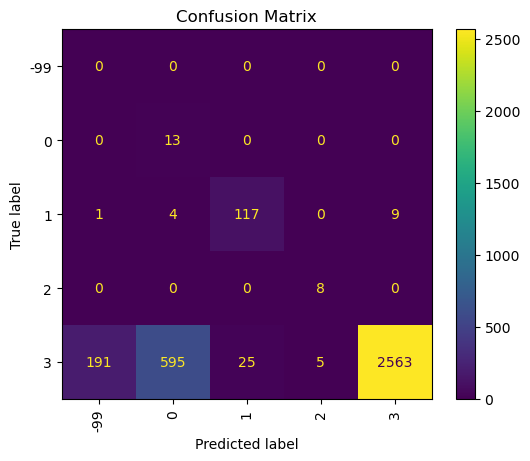

In [24]:
zero_shot_report("ms-diag_llama2-MedTuned_clm_line_paper-prompt_all.csv")

Exact match percentage:  0.46113989637305697
No matches:  1
                                          precision    recall  f1-score   support

                                no_match       0.00      0.00      0.00         0
  primary_progressive_multiple_sclerosis       0.32      1.00      0.48        13
  relapsing_remitting_multiple_sclerosis       0.99      0.77      0.87       131
secondary_progressive_multiple_sclerosis       0.67      0.50      0.57         8
                                   no_ms       0.86      0.90      0.88        41

                                accuracy                           0.80       193
                               macro avg       0.57      0.63      0.56       193
                            weighted avg       0.90      0.80      0.83       193



/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


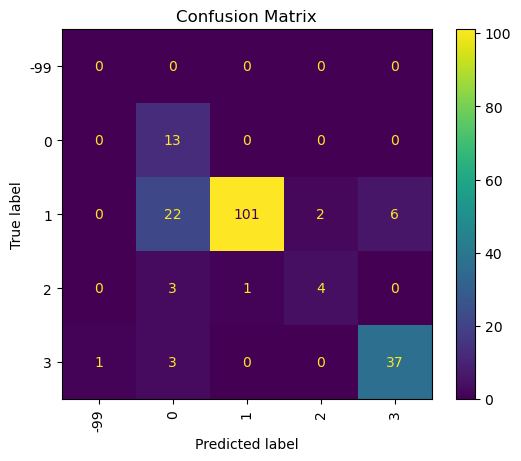

In [25]:
zero_shot_report("ms-diag_llama2-MedTuned_clm_all_paper-prompt_all.csv")

The difference in exact matches is because there are not as many reports, and especially not as many "no-info" reports.

Exact match percentage:  0.5181347150259067
No matches:  3
                                          precision    recall  f1-score   support

                                no_match       0.00      0.00      0.00         0
  primary_progressive_multiple_sclerosis       0.33      0.92      0.49        13
  relapsing_remitting_multiple_sclerosis       0.99      0.84      0.91       131
secondary_progressive_multiple_sclerosis       0.57      0.50      0.53         8
                                   no_ms       0.92      0.80      0.86        41

                                accuracy                           0.82       193
                               macro avg       0.56      0.61      0.56       193
                            weighted avg       0.91      0.82      0.85       193



/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


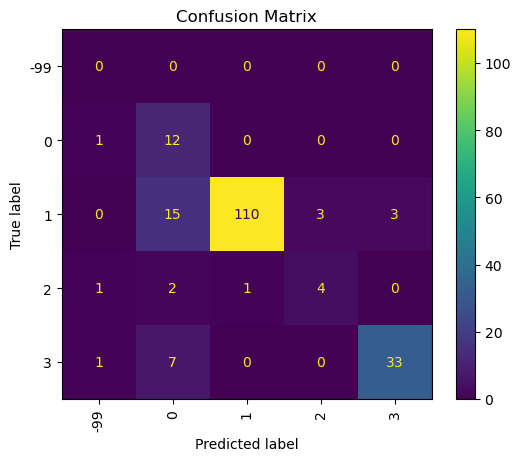

In [26]:
zero_shot_report("ms-diag_llama2-MedTuned_clm_first-last_paper-prompt_all.csv")

### Intermezzo: Sequence length and accuracy

In [27]:
# Log regression to find out input len and probability of correct classification
results_all = pd.read_csv(paths.RESULTS_PATH/"ms-diag"/"ms-diag_llama2-MedTuned_clm_all_paper-prompt_all.csv", index_col=0)
y = (results_all.labels == results_all.preds).astype(int)
X = results_all.input_len

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X.values.reshape(-1, 1), y.values)

print(clf.coef_)

[[-0.00029437]]
